# Patent Analysis : ESPACENET
***

### Basic Analysis 
- *Count the nomber of unique applicants* 
- *Count the number of unique inventors*
- *Number of application per year*
- *Distribution of patents per country*
### Temporal Analysis
- *Observe the patent Distribution over publication date*
- *Observe the patent Distribution over application date*
### Geographical Analysis
- *distribution of applicants and inventors around the world*
- *Collaboration network between the inventors*
### Text Analysis : NLP
- *Extract the language from the abstract*
- *Analyse the abstract (extract key words)*
- *Cluster patents into groups based on their abstract similarities.*

## 0- Libraries

In [64]:
# Preprocessing with spark
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col, to_date, year, split, array_distinct, concat_ws, explode, lit

# NLP with NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Language detection and translation
from langdetect import detect
from collections import Counter
from translate import Translator

# Visualization with sns and plt
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## 1 - Importing and Preprocessing the data from mongoDB

In [65]:
print(pyspark.__version__)

3.5.1


In [3]:
spark = SparkSession.builder \
    .appName("PatentAnalysis") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0") \
    .getOrCreate()

24/05/03 18:10:11 WARN Utils: Your hostname, Houdas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.11.112 instead (on interface en0)
24/05/03 18:10:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/anaconda3/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/houdamoudni/.ivy2/cache
The jars for the packages stored in: /Users/houdamoudni/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-add63e06-b700-4a78-bc8f-f1b850e81054;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 427ms :: artifacts dl 16ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||

In [4]:
# MongoDB Details
mongo_ip = "mongodb://127.0.0.1:27017/"
db_name = "espacenet_patent" 
collection_name = "espacenet_data"  

df = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option("uri", mongo_ip + db_name + "." + collection_name) \
    .load()

df.printSchema()

root
 |-- Applicants: string (nullable = true)
 |-- Applicants_country: string (nullable = true)
 |-- Date_Application: string (nullable = true)
 |-- Date__publication: string (nullable = true)
 |-- Inventors: string (nullable = true)
 |-- Inventors_country: string (nullable = true)
 |-- Patent_Application_id: string (nullable = true)
 |-- Patent_abstract: string (nullable = true)
 |-- Patent_publication_id: string (nullable = true)
 |-- Published_as: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



### II - Preprocessing the data

In [6]:
# TRANSFORM THE DATE_PUBLICATION FROM STRING TO DATE
df = df.withColumn("Date_publication", to_date(col("Date__publication"), "yyyy-MM-dd"))

In [7]:
df = df.withColumn("Date_application", to_date(col("Date_Application"), "yyyy-MM-dd"))

In [8]:
# REMOVE DUPLICATE VALUES WITHIN THE INVENTORS_COUNTRY
df_split = df.withColumn("Inventors_country_split", split(df["Inventors_country"], " & "))
df_cleaned = df_split.withColumn("Inventors_country_cleaned", array_distinct("Inventors_country_split"))
df_cleaned = df_cleaned.withColumn("Inventors_country", concat_ws(" & ", "Inventors_country_cleaned"))
df = df_cleaned.drop("Inventors_country_split", "Inventors_country_cleaned")
df.show()


+--------------------+------------------+----------------+-----------------+--------------------+-----------------+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+----------------+
|          Applicants|Applicants_country|Date_application|Date__publication|           Inventors|Inventors_country|Patent_Application_id|     Patent_abstract|Patent_publication_id|        Published_as|               Title|                 _id|Date_publication|
+--------------------+------------------+----------------+-----------------+--------------------+-----------------+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+----------------+
|IDEAS & MOTION S ...|                IT|      2022-05-20|       2022-11-25|GROPPO RICCARDO [...|               IT|           FR2204877A|Smart battery pac...|          FR3123155A3|DE202022001227U1 ...|Bloc-batterie in

In [9]:
# REMOVE DUPLICATE VALUES WITHIN THE APPLICANTS_COUNTRY
df_split = df.withColumn("Applicants_country_split", split(df["Applicants_country"], " & "))
df_cleaned = df_split.withColumn("Applicants_country_cleaned", array_distinct("Applicants_country_split"))
df_cleaned = df_cleaned.withColumn("Applicants_country", concat_ws(" & ", "Applicants_country_cleaned"))
df = df_cleaned.drop("Applicants_country_split", "Applicants_country_cleaned")
df.show()

+--------------------+------------------+----------------+-----------------+--------------------+-----------------+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+----------------+
|          Applicants|Applicants_country|Date_application|Date__publication|           Inventors|Inventors_country|Patent_Application_id|     Patent_abstract|Patent_publication_id|        Published_as|               Title|                 _id|Date_publication|
+--------------------+------------------+----------------+-----------------+--------------------+-----------------+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+----------------+
|IDEAS & MOTION S ...|                IT|      2022-05-20|       2022-11-25|GROPPO RICCARDO [...|               IT|           FR2204877A|Smart battery pac...|          FR3123155A3|DE202022001227U1 ...|Bloc-batterie in

In [10]:
data = df.toPandas()

for column in data.columns:
    data[f'{column}'] = data[f'{column}'].replace({'': 'NULL', ' ': 'NULL'})

In [11]:
df= spark.createDataFrame(data)

In [12]:
df.describe().show()

24/05/03 18:11:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------------+------------------+-----------------+--------------------------+-----------------+---------------------+----------------------------------+---------------------+--------------------+--------------------+
|summary|              Applicants|Applicants_country|Date__publication|                 Inventors|Inventors_country|Patent_Application_id|                   Patent_abstract|Patent_publication_id|        Published_as|               Title|
+-------+------------------------+------------------+-----------------+--------------------------+-----------------+---------------------+----------------------------------+---------------------+--------------------+--------------------+
|  count|                    1031|              1031|             1031|                      1031|             1031|                 1031|                              1031|                 1031|                1031|                1031|
|   mean|                    NULL|              

In [13]:
df.createOrReplaceTempView("patent_data")

In [14]:
spark.sql("SELECT * FROM patent_data").show(50)

+--------------------+------------------+----------------+-----------------+--------------------+-----------------+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+----------------+
|          Applicants|Applicants_country|Date_application|Date__publication|           Inventors|Inventors_country|Patent_Application_id|     Patent_abstract|Patent_publication_id|        Published_as|               Title|                 _id|Date_publication|
+--------------------+------------------+----------------+-----------------+--------------------+-----------------+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+----------------+
|IDEAS & MOTION S ...|                IT|      2022-05-20|       2022-11-25|GROPPO RICCARDO [...|               IT|           FR2204877A|Smart battery pac...|          FR3123155A3|DE202022001227U1 ...|Bloc-batterie in

## 2 -  Basic Analysis

###  1. Count the nomber of unique applicants and Inventors 

In [15]:
table = spark.sql("select distinct(Applicants) from patent_data")
print(f"Nomber of unique Applicants {table.count()}")
table.show()

Nomber of unique Applicants 364
+--------------------+
|          Applicants|
+--------------------+
|      LEAR CORP [US]|
|     PORSCHE AG [DE]|
|BOSCH GMBH ROBERT...|
|TOYOTA MOTOR CO L...|
|SIEMENS INDUSTRY ...|
|XINWANDA ELECTRIC...|
|  UNIV TSINGHUA [CN]|
|BVB INNOVATE GMBH...|
|ZERO EMISSION SYS...|
|BEIJING PRIDE NEW...|
|GUILIN GEELY STAR...|
|FORD GLOBAL TECH ...|
|CONSTELLIUM NEUF ...|
|    ALTRA S P A [IT]|
|BOSCH GMBH ROBERT...|
|SUNWODA ELECTRIC ...|
|GONZALEZ MENA FRA...|
|  WIEGER MARTIN [AT]|
| MIDTRONICS INC [US]|
|HUNAN CRRC TIMES ...|
+--------------------+
only showing top 20 rows



In [16]:
table = spark.sql("select distinct(Inventors) from patent_data")
print(f"Nomber of unique Inventors {table.count()}")
table.show()

Nomber of unique Inventors 892


+--------------------+
|           Inventors|
+--------------------+
|   SEABERG SETH [US]|
|STADLER MATTHIAS ...|
|PANDIT S B RAVI [...|
|MILOSIU JOHANN-MA...|
|MUELLER FRANZISKA...|
|ISHIKAWA TETSUHIR...|
|JUAN SYLVAIN [FR]...|
|MILLER GARRET [US...|
|TREMBLAY HANS [CA...|
|WINDSCHIEGL ARMIN...|
|LEI JINGJING and ...|
|ZHOU JIE and  YAN...|
|QUET PIERRE-FRANÇ...|
|YUAN MINGFU and  ...|
|JEFFERIES KEVIN M...|
|GONZALEZ MENA FRA...|
|  WIEGER MARTIN [AT]|
|HARRIS TIMOTHY [U...|
|KIM BO HYUN [KR] ...|
|WANG SHIYING and ...|
+--------------------+
only showing top 20 rows



### 2. Nombre of patent invented (applicated) by each inventor (Applicant)

In [17]:
table = spark.sql("select Applicants, count(Applicants) as nomber_patent from patent_data GROUP BY Applicants ORDER BY nomber_patent DESC")
table.show()

+--------------------+-------------+
|          Applicants|nomber_patent|
+--------------------+-------------+
|BEIJING ELECTRIC ...|          180|
|FORD GLOBAL TECH ...|           70|
|SHENZHEN OPTIMUM ...|           38|
|SUNWODA ELECTRIC ...|           29|
|TIANJIN AIMA VEHI...|           21|
|BOSCH GMBH ROBERT...|           20|
|  VOLKSWAGEN AG [DE]|           20|
|ZHEJIANG LUYUAN E...|           20|
|BAYERISCHE MOTORE...|           15|
|SHENJIANG ELECTRI...|           15|
|XINWANDA ELECTRIC...|           10|
|JIANGSU AIMA VEHI...|           10|
|ZHIDOU ELECTRIC V...|            8|
|        AUDI AG [DE]|            8|
|VITESCO TECH GMBH...|            8|
|ARTISAN VEHICLE S...|            8|
|NIDEC PSA EMOTORS...|            8|
|CHONGQING HUANNEN...|            7|
|TIANJIN QINGYUAN ...|            6|
|LIMA VEHICLE GROU...|            6|
+--------------------+-------------+
only showing top 20 rows



In [18]:
table = spark.sql("select Inventors, count(Inventors) as nomber_patent from patent_data GROUP BY Inventors ORDER BY nomber_patent DESC")
table.show()

+--------------------+-------------+
|           Inventors|nomber_patent|
+--------------------+-------------+
|LI HONGJIAN and  ...|            8|
|YU XIAOMING and  ...|            7|
|HU JIE and  XU MI...|            6|
|        WANG JIANHAI|            5|
|            ZHU YUAN|            4|
|HUFF BRIAN R [US]...|            4|
|       YONGJUN ZHANG|            4|
|            LI XIANG|            4|
|         WANG YUFENG|            4|
|YUAN MINGFU and  ...|            3|
|ZHAO JIYANG and  ...|            3|
|BERTNESS KEVIN I ...|            3|
|WANG JINLONG and ...|            3|
|NI JIE and  ZHOU ...|            3|
|      ZHANG JIANCHUN|            3|
|JING GUITANG and ...|            3|
|FENG FUCHUN and  ...|            3|
|SU YONGWEI and  Z...|            3|
|         GAO FENGLOU|            3|
|           LUO TAIFA|            3|
+--------------------+-------------+
only showing top 20 rows



### 3. Number of patent per country

In [19]:
table = spark.sql("select count(*) as number_patent, Inventors_country  from patent_data GROUP BY Inventors_country ORDER BY number_patent DESC")
table.show()

+-------------+-----------------+
|number_patent|Inventors_country|
+-------------+-----------------+
|          709|             NULL|
|          110|               US|
|           98|               DE|
|           25|               FR|
|           19|               CN|
|           18|               JP|
|           10|               KR|
|            7|               IT|
|            4|               AT|
|            4|               CA|
|            4|               GB|
|            3|               ES|
|            2|          DE & US|
|            2|          CA & US|
|            2|          US & CA|
|            2|               TW|
|            1|               IN|
|            1|               SE|
|            1|          DE & CZ|
|            1|          DE & AT|
+-------------+-----------------+
only showing top 20 rows



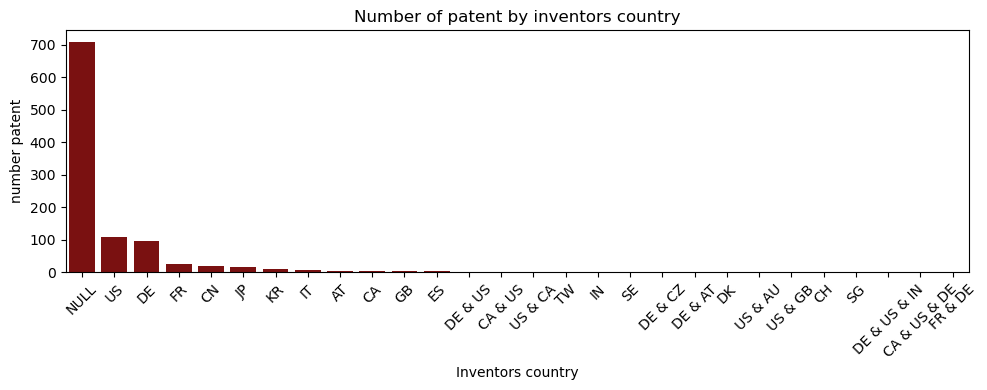

In [20]:
pd_table = table.toPandas()
plt.figure(figsize=(10, 4))
sns.barplot(x='Inventors_country', y='number_patent', data=pd_table, color='darkred')
plt.title('Number of patent by inventors country')
plt.xlabel('Inventors country')
plt.ylabel('number patent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3 - Temporal Analysis

### 1. Patent distribution per year

In [21]:
df_year = df.withColumn("Date_publication", year(col("Date_publication")))
year_table = df_year.createOrReplaceTempView("year_table")
table = spark.sql("select count(*) as number_patent, Date_publication  from year_table GROUP BY Date_publication ORDER BY number_patent DESC")
table.show()

+-------------+----------------+
|number_patent|Date_publication|
+-------------+----------------+
|          138|            2020|
|          136|            2021|
|          115|            2018|
|          104|            2023|
|          103|            2022|
|           80|            2017|
|           70|            2019|
|           60|            2016|
|           54|            2015|
|           51|            2014|
|           26|            2012|
|           20|            2013|
|           14|            2024|
|           11|            2007|
|            9|            2010|
|            8|            2011|
|            5|            2002|
|            3|            2000|
|            3|            2008|
|            2|            2003|
+-------------+----------------+
only showing top 20 rows



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


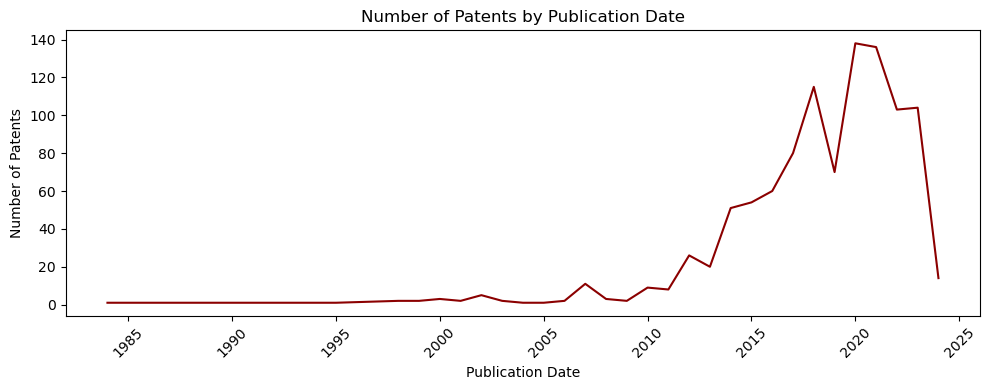

In [22]:
pd_table = table.toPandas()
plt.figure(figsize=(8, 4))
sns.lineplot(x='Date_publication', y='number_patent', data=pd_table, color='darkred')
plt.title('Number of Patents by Publication Date')
plt.xlabel('Publication Date')
plt.ylabel('Number of Patents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4 - Geographical Analysis

### 1. distribution of applicants and inventors around the world

In [23]:
df_applicants_country = df.withColumn("applicants_country", explode(split(col("applicants_country"), " & ")))
applicants_country_count = df_applicants_country.groupBy("applicants_country").count()
applicants_country_count.show()

+------------------+-----+
|applicants_country|count|
+------------------+-----+
|                CN|   19|
|                AT|    3|
|                CA|    5|
|                GB|    3|
|                DE|  104|
|                ES|    1|
|                KR|   19|
|                US|  120|
|                IN|    1|
|                FR|   26|
|                IT|    7|
|                SE|    1|
|                JP|   19|
|              NULL|  703|
|                DK|    1|
|                CH|    1|
|                SG|    1|
|                TW|    2|
+------------------+-----+



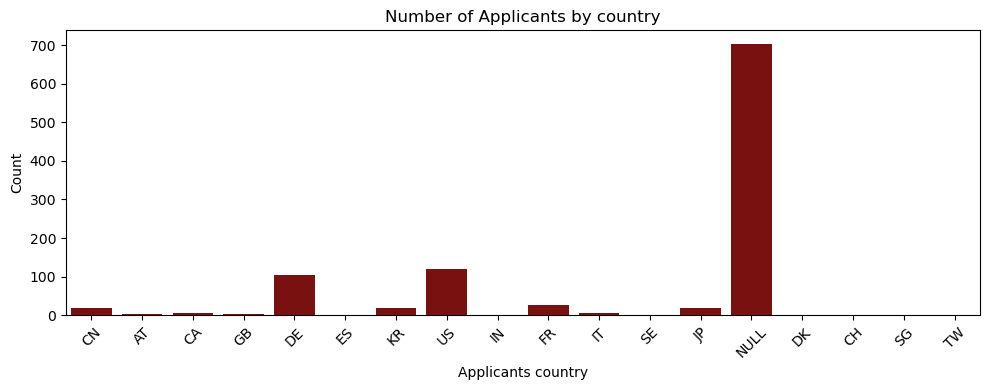

In [24]:
pd_table = applicants_country_count.toPandas()

plt.figure(figsize=(8, 4))
sns.barplot(x='applicants_country', y='count', data=pd_table, color='darkred')
plt.title('Number of Applicants by country')
plt.xlabel('Applicants country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
df_inventors_country = df.withColumn("inventors_country", explode(split(col("inventors_country"), " & ")))
inventors_country_count = df_inventors_country.groupBy("inventors_country").count()
inventors_country_count.show()

+-----------------+-----+
|inventors_country|count|
+-----------------+-----+
|               CN|   19|
|               AT|    5|
|               CZ|    1|
|               AU|    1|
|               CA|    9|
|               GB|    5|
|               DE|  105|
|               ES|    3|
|               KR|   10|
|               US|  120|
|               IN|    2|
|               FR|   26|
|               IT|    7|
|               SE|    1|
|               JP|   18|
|             NULL|  709|
|               DK|    1|
|               CH|    1|
|               SG|    1|
|               TW|    2|
+-----------------+-----+



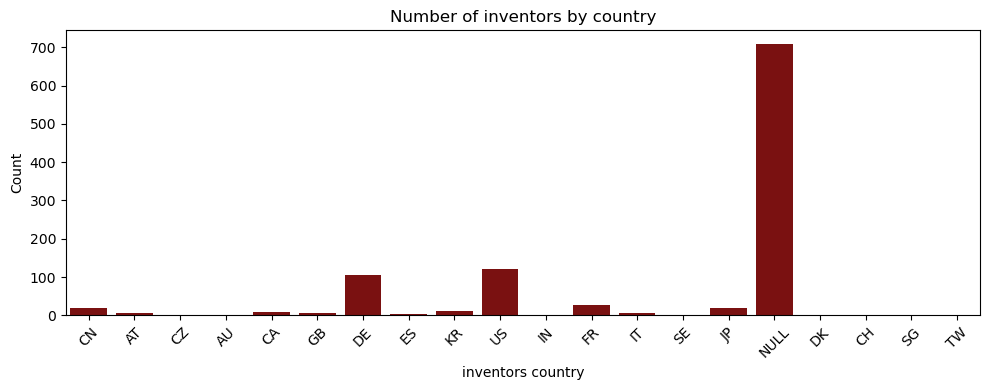

In [26]:
pd_table = inventors_country_count.toPandas()

plt.figure(figsize=(8, 4))
sns.barplot(x='inventors_country', y='count', data=pd_table, color='darkred')
plt.title('Number of inventors by country')
plt.xlabel('inventors country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2. Collaboration network between the inventors

In [27]:
df_collaborations = df.filter(col("Inventors_country").contains("&"))
collaborations_count = df_collaborations.groupBy("inventors_country").count()
collaborations_count.show()

+-----------------+-----+
|inventors_country|count|
+-----------------+-----+
|          DE & US|    2|
|          CA & US|    2|
|          US & CA|    2|
|          DE & CZ|    1|
|          DE & AT|    1|
|          US & AU|    1|
|          US & GB|    1|
|     DE & US & IN|    1|
|     CA & US & DE|    1|
|          FR & DE|    1|
+-----------------+-----+



In [28]:
df_collaborations = df.filter(col("Applicants_country").contains("&"))
collaborations_count = df_collaborations.groupBy("Applicants_country").count()
collaborations_count.show()

+------------------+-----+
|Applicants_country|count|
+------------------+-----+
|           DE & KR|    3|
|           DE & JP|    1|
|           DE & SG|    1|
+------------------+-----+



## 5 - Text Analysis

### 1. Extract Language from the abstract

In [29]:
# transform the preprocessed data with pyspark into a dataframe
pd_data = df.toPandas()

In [30]:
languages = {}
for index, abstract in enumerate(pd_data["Patent_abstract"]):

    # Detecte the language
    detected_language = detect(abstract)
    languages[f"Abstract {index}"] = detected_language

language_counts = Counter(languages.values())

print("Language Counts: ")
for language, counts in language_counts.items():
    print(f"Language : {language} -> {counts}")

Language Counts: 
Language : en -> 866
Language : de -> 139
Language : fr -> 16
Language : ko -> 9
Language : zh-cn -> 1


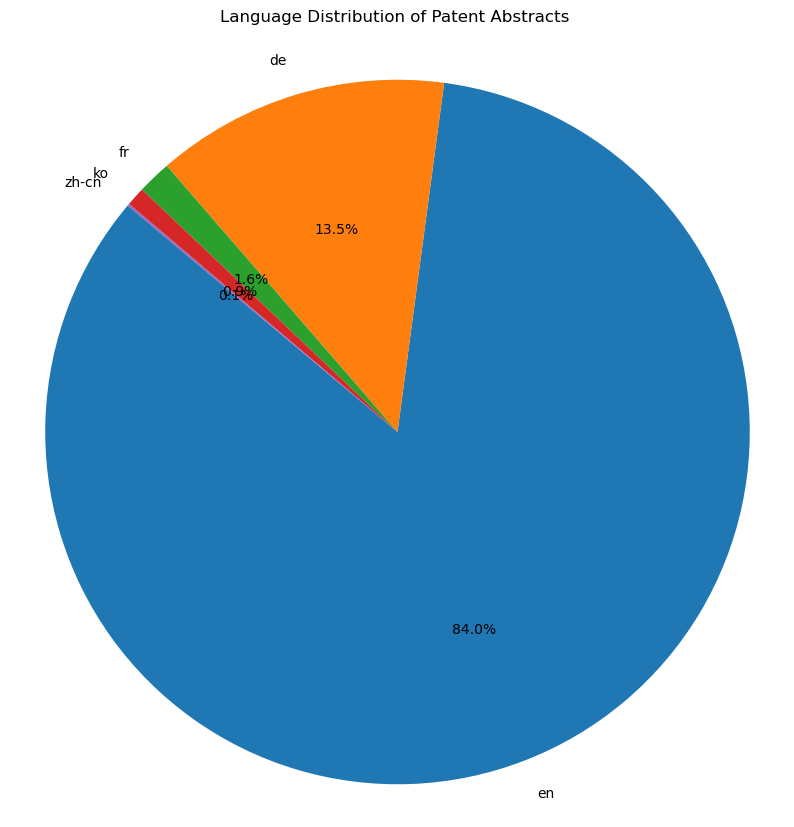

In [33]:
plt.figure(figsize=(10, 10))
plt.pie(list(language_counts.values()), labels=list(language_counts.keys()), autopct='%1.1f%%', startangle=140)
plt.title('Language Distribution of Patent Abstracts \n')
plt.axis('equal') 
plt.show()

### 2. Extract key words from the abstract

### 3. Translate the Patent Abstract to English

In [ ]:
for index, abstract in enumerate(pd_data["Patent_abstract"]):
    detected_language = detect(abstract)

    if detected_language != 'en':
        
        translator= Translator(to_lang="English")
        translation = translator.translate(abstract)
   
        print(f"---------- Translated Abstract {index} ----------")
        print(translation.text)
        
### There are errors to debug

### 3. Ploting the WordCloud

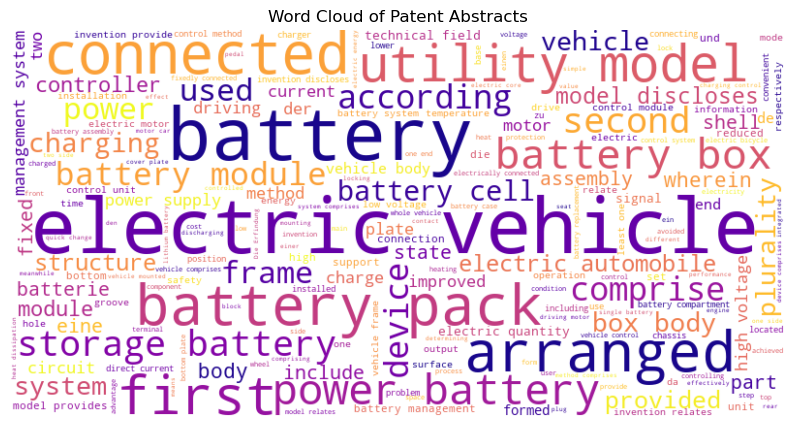

In [36]:
# Join all the abstracts into a single string
all_abstracts = ' '.join(pd_data["Patent_abstract"])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(all_abstracts)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Patent Abstracts')
plt.axis('off')
plt.show()


**Big Data With Spark**
****
*NoteBook* : Analyzing the patent's metadata scraped from espacenet using pySpark